In [1]:
import numpy as np
from matplotlib import pyplot as plt
# TODO: add torch

In [2]:
toy_A = np.array([[3,2],[2,6]])
toy_b = np.array([[2],[-8]])

In [3]:
def steepest_descent(A, b, x0, max_iter=int(1e5), tol=1e-5, recompute=None):
    """
    Solving Ax = b or min(0.5xTAx - bTx + c)
    Steepest descent is at orthogonal to the previous one in each iteration.
    Suitable for scipy sparse and numpy dense arrays.
    Using fast iterative update of residual, rounding errors accumulates.

    A: dense or sparse matrix
    b, x0: column vectors
    recompute: number of iterations to recompute the exact residual, infered if not given

    returns:
        x: final x
        r: final residual
        num_iter: number of iterations run
    """
    if recompute is None:
        recompute = np.sqrt(A.shape[0])
    recompute = int(recompute)

    x = x0
    r = b - A@x
    delta = r.T@r
    tolerance = tol**2 * delta # when ||r_i|| <= tol * ||r_0||
    num_iter = max_iter
    for i in range(max_iter):
        q = A@r
        alpha = delta / (r.T@q)
        x = x + alpha *r
        if i % recompute == 0:
            r = b - A@x
        else:
            r = r - alpha*q
        delta = r.T@r

        if delta <= tolerance:
            num_iter = i+1
            break
    return x, r, num_iter

In [4]:
x0 = np.array([[-1],[-2]])
x, r, num = steepest_descent(toy_A, toy_b, x0, tol=1e-9)
print(num, " iterations taken to get result ", x.T, " with residual ", r.T)

30  iterations taken to get result  [[ 2. -2.]]  with residual  [[7.84016407e-09 5.22677546e-09]]


In [5]:
def CG(A, b, x0, max_iter=int(1e5), tol=1e-5, recompute=None):
    """
    Solving Ax = b or min(0.5xTAx - bTx + c)
    Conjugated gradient starts with the first descent direction as d0,
    The rest of the directions are all mutually A-orthogonal and can be built from d0,
    Thus, one direction only need to descend once
    Suitable for scipy sparse and numpy dense arrays.
    Using fast iterative update of residual, rounding errors accumulates.

    A: dense or sparse matrix
    b, x0: column vectors
    recompute: number of iterations to recompute the exact residual, infered if not given

    returns:
        x: final x
        r: final residual
        num_iter: number of iterations run
    """
    if recompute is None:
        recompute = np.sqrt(A.shape[0])
    recompute = int(recompute)

    x = x0
    r = b - A@x
    d = r
    delta_new = r.T@r
    tolerance = tol**2 * delta_new # when ||r_i|| <= tol * ||r_0||
    num_iter = max_iter
    for i in range(max_iter):
        q = A@d
        alpha = delta_new / (d.T@q)
        x = x + alpha * d
        if i % recompute == 0:
            r = b - A@x
        else:
            r = r - alpha*q

        delta_old = delta_new
        delta_new = r.T@r
        beta = delta_new/delta_old
        d = r + beta*d
        
        if delta_new <= tolerance:
            num_iter = i+1
            break
    return x, r, num_iter

In [6]:
x0 = np.array([[-1],[-2]])
x, r, num = CG(toy_A, toy_b, x0, tol=1e-9)
print(num, " iterations taken to get result ", x.T, " with residual ", r.T)

2  iterations taken to get result  [[ 2. -2.]]  with residual  [[0. 0.]]


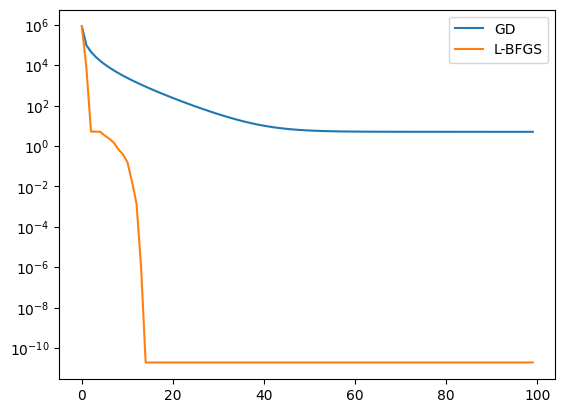

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


# 2d Rosenbrock function
def f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

 
# Gradient descent
x_gd = 10*torch.ones(2, 1)
x_gd.requires_grad = True
gd = optim.SGD([x_gd], lr=1e-5)
history_gd = []
for i in range(100):
    gd.zero_grad()
    objective = f(x_gd)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())


# L-BFGS
def closure():
    lbfgs.zero_grad()
    objective = f(x_lbfgs)
    objective.backward()
    return objective

x_lbfgs = 10*torch.ones(2, 1)
x_lbfgs.requires_grad = True

lbfgs = optim.LBFGS([x_lbfgs],
                    history_size=10, 
                    max_iter=4, 
                    line_search_fn="strong_wolfe")
                    
history_lbfgs = []
for i in range(100):
    history_lbfgs.append(f(x_lbfgs).item())
    lbfgs.step(closure)


# Plotting
plt.semilogy(history_gd, label='GD')
plt.semilogy(history_lbfgs, label='L-BFGS')
plt.legend()
plt.show()

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os 
sys.path.append(os.path.abspath('../'))
import torch
import functools
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt 

device = 'cuda'

from utils_fns import *
from utils_general import update_sigma_linear, run_scheduler_step, plt_errors, show_with_error


def get_rendering(theta, update_fn=None, ctx_args=None): 
  return draw_rect(theta[0], theta[1])


def draw_rect(px, py):   
  s, w, h, exp = 256, 0.1, 0.1, 10
  ss = torch.linspace(0, 1, s, device=device)
  x, y = torch.meshgrid(ss, ss)
  image = 1 - 2*(abs(((py - x)/w))**exp + abs((y - px)/h)**exp)
  return torch.flipud(image.clamp(0, 1)).unsqueeze(-1)


def render_smooth(perturbed_theta, update_fn, ctx_args):
  with torch.no_grad():
      imgs, losses = [], []
      for j in range(perturbed_theta.shape[0]):       # for each sample
          perturbed_img = get_rendering(perturbed_theta[j, :])
          perturbed_loss = torch.nn.MSELoss()(perturbed_img, ctx_args['gt_image'])
          imgs.append(perturbed_img)
          losses.append(perturbed_loss)

      avg_img = torch.mean(torch.cat([x.unsqueeze(0) for x in imgs], dim=0), dim=0)
      loss = torch.stack(losses)
  return loss, avg_img

In [3]:

def grad_torch(func, x, ctx, *args):
    '''
    x is a row vector with one extra dimension [[a, b, c, ...]]
    returns the gradient as a row vector with same shape as x
    '''
    y, _ = func(x, ctx)
    grad = torch.autograd.grad(y, x)[0]
    return grad

def grad_fd(func, x, ctx, epsilon=1e-6):
    '''
    To get gradient of a function using finite difference
    However, the smooth rendering function arleady has a forward pass that is the gradient instead of the actual function
    So we should treat the result of the func as the gradient, and not calculate its gradient again
    '''
    grad = torch.zeros_like(x)
    for i in range(x.size(0)):
        x_p = x.clone()
        x_n = x.clone()
        x_p[i] += epsilon
        x_n[i] -= epsilon
        y_p, _ = func(x_p, ctx)
        y_n, _ = func(x_n, ctx)
        grad[i] = (y_p - y_n) / 2 / epsilon
    return grad

def hessian_fd(func, x, ctx, grad_fn=grad_torch, epsilon=1e-4):
    '''
    x is a row vector with one extra dimension [[a, b, c, ...]]
    '''
    new_x = x.clone()
    new_x = new_x.view(1,-1) # ensures a row vector
    n = new_x.size(1)
    hessian_matrix = torch.zeros((n, n), device=device)
        
    for i in range(n):
        # Perturb the i-th element
        x_pi = new_x.clone()
        x_ni = new_x.clone()
        x_pi[0,i] += epsilon
        x_ni[0,i] -= epsilon
        # Compute the gradient vectors at the perturbed point
        # thess will be the column vector df/dx_(1~n) dx_i
        par_pi = grad_fn(func, x_pi, ctx, epsilon)
        par_ni = grad_fn(func, x_ni, ctx, epsilon)
        # Compute the second-order partial derivatives
        hessian_matrix[i] =  (par_pi - par_ni) / 2 / epsilon
    return hessian_matrix.T

def hessian_check(func, x, ctx, epsilon=1e-8):
    '''Check with tools'''
    def get_func_numpy(theta, *args):
        theta = torch.tensor(theta, device=device, dtype=torch.float32) 
        theta = theta.unsqueeze(0)
        result, _ = func(theta, *args)
        return result.cpu().detach().numpy()
    new_x = x.clone()
    x_num = new_x.clone().squeeze().cpu().detach().numpy() 
    Hfun = nd.Hessian(get_func_numpy, step=epsilon)
    hessian_nd = Hfun(x_num, ctx)
    return hessian_nd

In [29]:
#@title Set Algorithm Parameters { run: "auto", form-width: "25%", display-mode: "both" }
n_samples = 4 #@param {type:"slider", min:1, max:20, step:1}
sigma = 0.01 #@param {type:"slider", min:0.01, max:0.15, step:0.01}

hparams = {'nsamples': n_samples,
           'sigma': sigma,
           'learning_rate': 1e-3,
           'sigma_annealing': True,
           'epochs': 500,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.05,
           'tol': 1e-6, # tolerance for CG
           'NR_max_iter': 100, # max iter for NR line search in CG
           'NR_tol': 1e-6, # tolerance for NR line search in CG
           'recompute': 10, # recompute the exact residual every n iterations
           'hessian_epsilon': 1e-4, # perturb size for hessian computation
           'plot_interval':100 # number of iterations to plot
           }

torch.manual_seed(0)
sigma = hparams['sigma']

# set up initial and gt translation:
theta = torch.tensor([0.5, 0.66], requires_grad=True, device=device)
gt_theta = torch.tensor([0.5, 0.33], device=device)

# set up optim:
optim = torch.optim.Adam([theta], lr=hparams['learning_rate'])

init_img = get_rendering(theta)
ref_img = get_rendering(gt_theta)

# set up ctx_args: 
ctx_args = {'antithetic': True, 'nsamples': hparams['nsamples'], 'sigma': hparams['sigma'],
            'sampler': 'importance', 'device': device, 'gt_image': ref_img, 'update_fn': None}

In [30]:
# set up smoothed renderer
get_smoothed_loss = smoothFn(render_smooth,
                             context_args=None,
                             device=ctx_args['device'])

x = torch.tensor([0.5, 0.66], requires_grad=True, device=device)
n = 100
hess_torch = 0
hess_check = 0
hess_fd = 0
for i in range(n):
    hess_torch += hessian_fd(get_smoothed_loss, x.unsqueeze(0), ctx_args, grad_fn=grad_torch) # pytorch
    # hess_fd += hessian_fd(get_smoothed_loss, x.unsqueeze(0), ctx_args, grad_fn=grad_fd) # fd
    # hess_check += hessian_check(get_smoothed_loss, x.unsqueeze(0), ctx_args) # numdifftools
    
# print(hess_check/100)
# print(hess_fd/100)
print(hess_torch/100)

tensor([[-0.0544, -0.0542],
        [-0.0343, -0.0135]], device='cuda:0')


In [39]:
def NCG(f, x0, max_iter, diff, hess, **f_args):
    """
    Non-linear CG for minimizing the SmoothFn.
    x0: initial guess as a row vector
    """
    tol = f_args['opt_args']['tol']
    NR_max_iter = f_args['opt_args']['NR_max_iter']
    NR_tol = f_args['opt_args']['NR_tol']
    recompute = f_args['opt_args']['recompute']
    hessian_epsilon = f_args['opt_args']['hessian_epsilon']
    interval = f_args['opt_args']['plot_interval']
    
    img_errors, param_errors = [], []
    x = x0.unsqueeze(0)
    k = 0
    r = -diff(f, x, f_args["ctx_args"]).T # r should be column vector
    d = r
    delta_new = (r.T@r).item()
    tolerance = tol**2 * delta_new # when ||r_i|| <= tol * ||r_0||
    num_iter = max_iter
    for i in range(max_iter):
        delta_d = d.T@d
        for j in range(NR_max_iter): # newton-ralph approximation
            denom = d.T@hess(f,x,f_args["ctx_args"], epsilon=hessian_epsilon)@d
            if i == 0:
                assert denom != 0, "try a new starting point"
            alpha = -(diff(f, x, f_args["ctx_args"])@d / denom).item()
            x = x + alpha*d.squeeze()
            if alpha**2 * delta_d <= NR_tol:
                break
        r = -diff(f, x, f_args["ctx_args"]).T
        delta_old = delta_new
        delta_new = r.T@r
        beta = delta_new/delta_old
        d = r + beta*d
        if k>=recompute or r.T@d <=0: # restart whenever a search direction is computed that is not descent direction
            k = 0
            d = r

        if delta_new <= tolerance:
            num_iter = i+1
            print("Converged at ", i+1)
            break
        img_errors, param_errors = logging(x, img_errors, param_errors, i, interval=interval)
    return x, r, num_iter

def logging(theta, img_errors, param_errors, i, interval=5):
    # plotting, logging, printing...
    theta = theta.squeeze()
    img_curr = get_rendering(theta)
    img_loss = torch.nn.MSELoss()(img_curr, ref_img).item()
    param_loss = torch.nn.MSELoss()(theta, gt_theta).item()
    img_errors.append(img_loss)
    param_errors.append(param_loss)

    if (i+1) % interval == 0: 
        print(f"Iter {i+1}/{hparams['epochs']} - Img.Loss: {img_loss:.4f} - Param.Loss: {param_loss:.4f}")
        show_with_error(img_curr, ref_img, iter=i+1)
        plt_errors(img_errors, param_errors, title=f'Iter {i+1}')
    return img_errors, param_errors

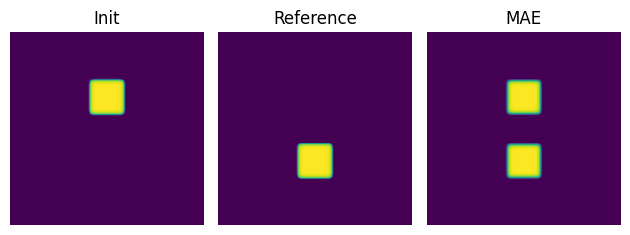

Iter 50/500 - Img.Loss: 0.0516 - Param.Loss: 0.0435


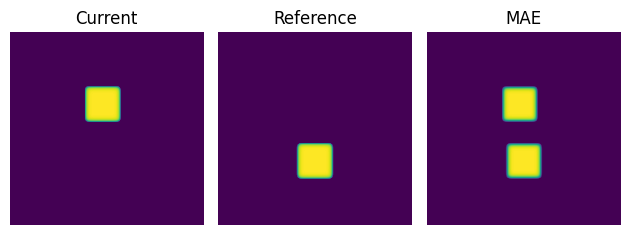

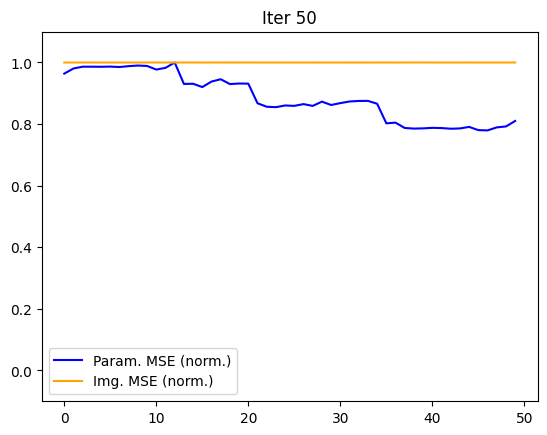

Iter 100/500 - Img.Loss: 0.0516 - Param.Loss: 0.0511


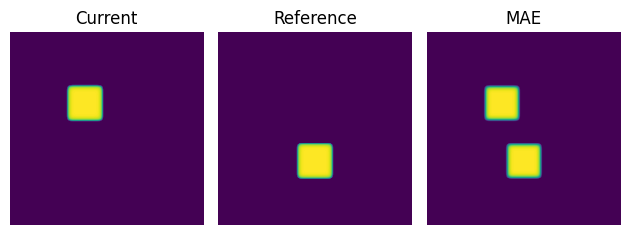

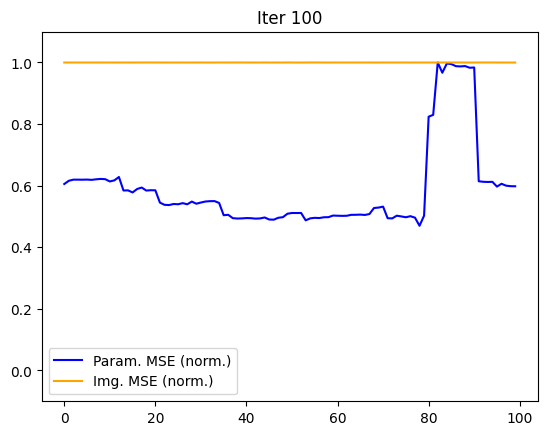

Iter 150/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


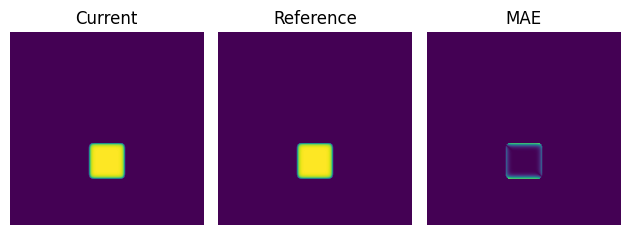

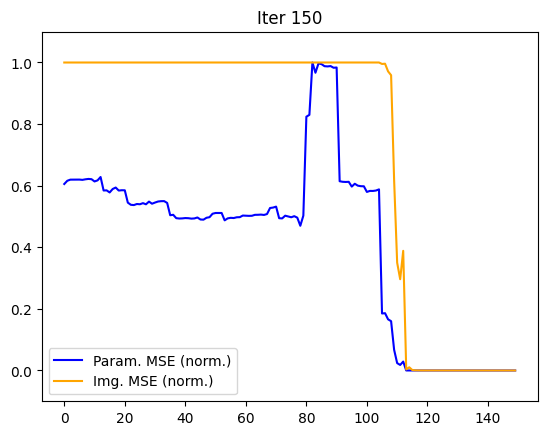

Iter 200/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


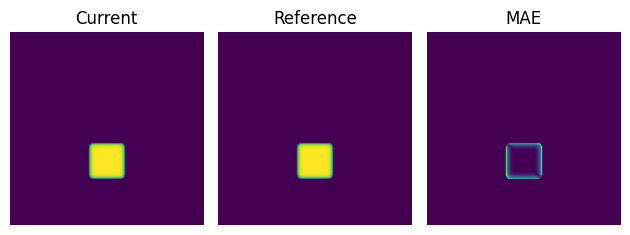

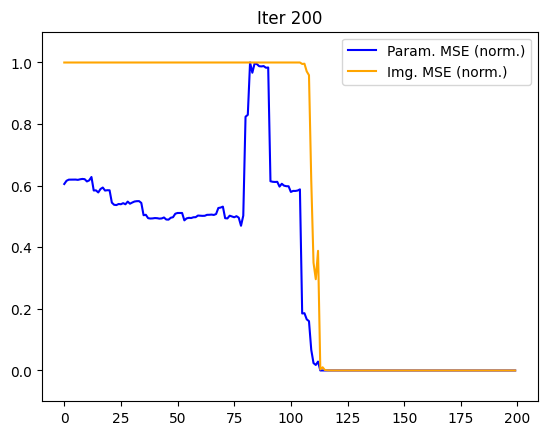

Iter 250/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


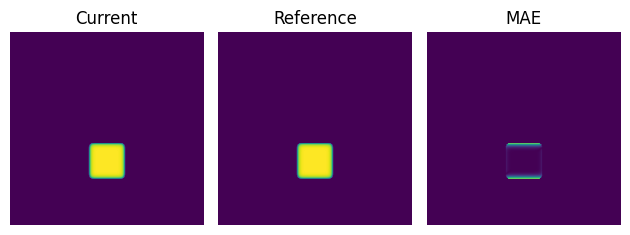

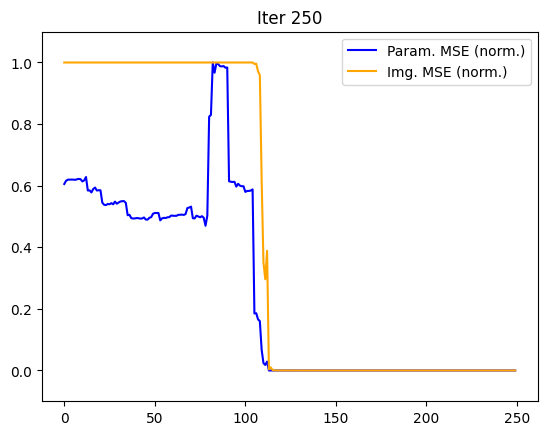

Iter 300/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


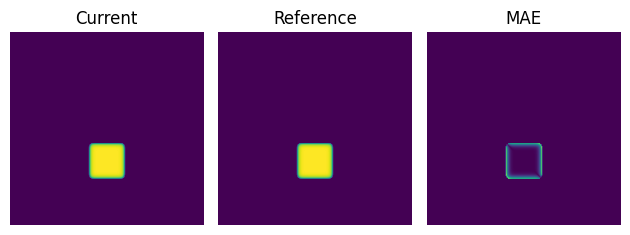

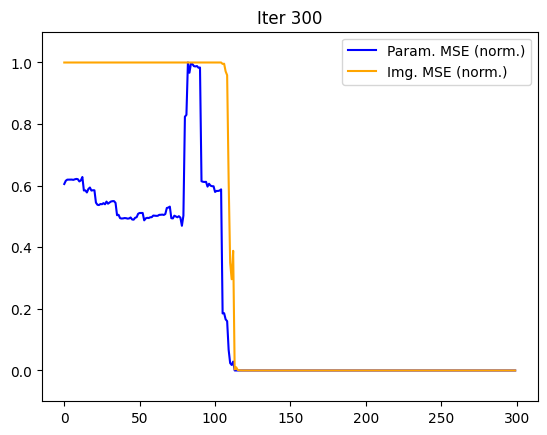

Iter 350/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


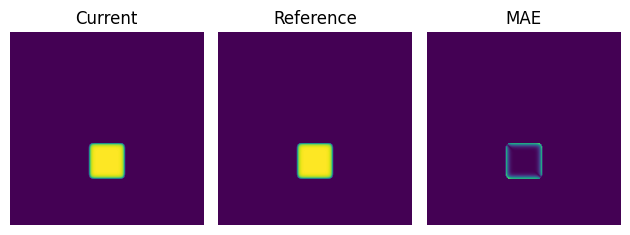

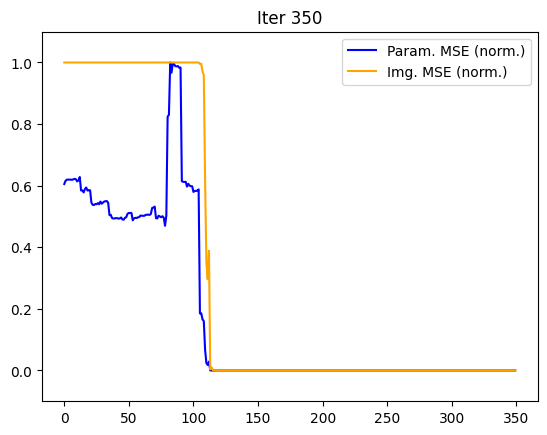

Iter 400/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


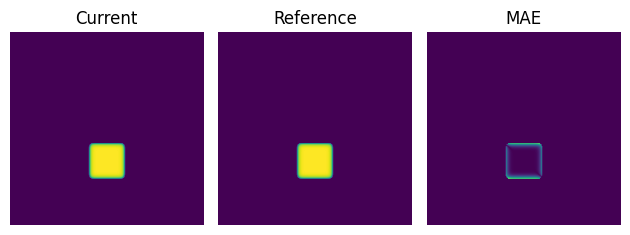

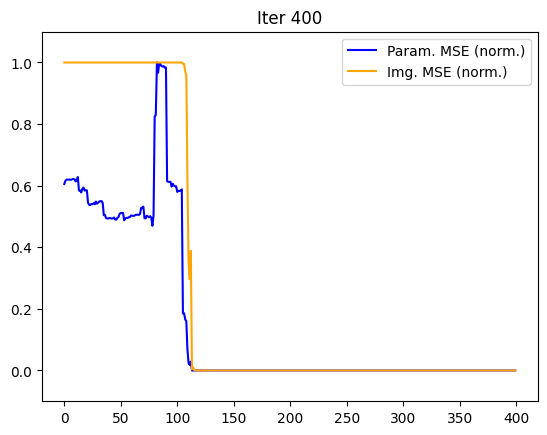

Iter 450/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


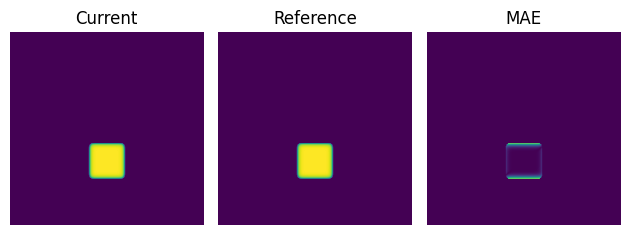

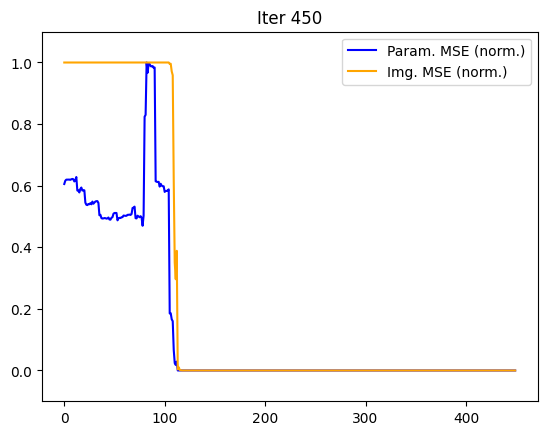

Iter 500/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


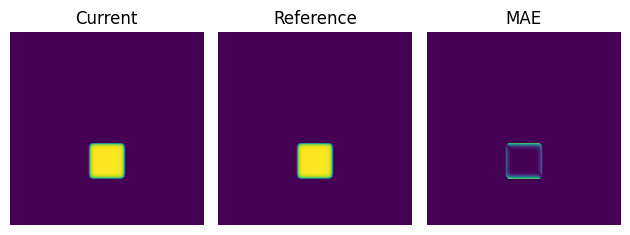

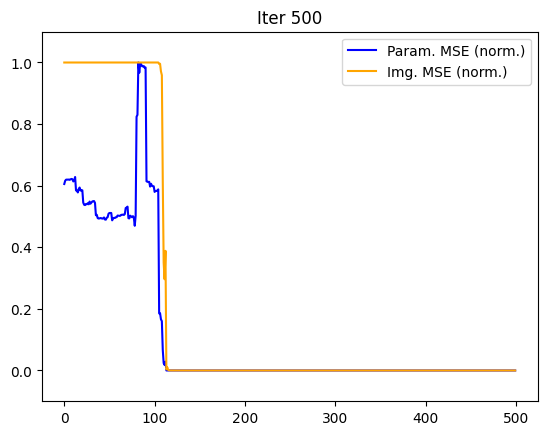

(tensor([[0.5000, 0.3299]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[ 0.0009],
         [-0.0002]], device='cuda:0'),
 500)

In [41]:
show_with_error(init_img, ref_img, iter=0)
# plt.rcParams['figure.figsize'] = (12, 6)
hparams = {'nsamples': n_samples,
           'sigma': sigma,
           'learning_rate': 1e-3,
           'sigma_annealing': True,
           'epochs': 500,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.05,
           'tol': 1e-7, # tolerance for CG
           'NR_max_iter': 200, # max iter for NR line search in CG
           'NR_tol': 1e-5, # tolerance for NR line search in CG
           'recompute': 10, # recompute the exact residual every n iterations
           'hessian_epsilon': 1e-3, # perturb size for hessian computation
           'plot_interval':50 # number of iterations to plot
           }
# set up smoothed renderer
get_smoothed_loss = smoothFn(render_smooth,
                             context_args=None,
                             device=ctx_args['device'])

# --------------- run optimization
max_iter = hparams['epochs']
x = theta.requires_grad_(True)
NCG(get_smoothed_loss, x, max_iter, grad_torch, hessian_fd, opt_args=hparams, ctx_args=ctx_args)

    # sigma scheduling:
    # if i > hparams['anneal_const_first'] and hparams['sigma_annealing'] and sigma >= hparams['anneal_sigma_min']:
    #     sigma = run_scheduler_step(sigma, curr_iter=i+1, sigma_initial=hparams['sigma'], sigma_min=hparams['anneal_sigma_min'], 
    #                                n=hparams['epochs'], const_first_n=hparams['anneal_const_first'], const_last_n=hparams['anneal_const_last'])
    #     ctx_args['sigma'] = sigma